### Questions tagging with NLP: Case of StackOvrFlow

In [62]:
# Importing librairies
import pandas as pd
import nltk
import numpy as np
from bs4 import BeautifulSoup
import stop_words
import re, sys
import spacy
from gensim.models import Phrases, phrases
from gensim import models, corpora
import pyLDAvis.gensim
from gensim.models import coherencemodel
from gensim.models.coherencemodel import CoherenceModel
from time import sleep
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Importing necessary tools

In [2]:
# Loading CSV File
data = pd.read_csv('QueryResults.csv')
data.head(3)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,4,1,7.0,NaN,2008-07-31 21:42:52,NaN,564,36447.0,<p>I want to use a track-bar to change a form'...,8.0,...,Rich B,2018-07-02 17:55:27,2018-07-02 17:55:27,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,13.0,2,41.0,NaN,2012-10-31 16:42:47
1,6,1,31.0,NaN,2008-07-31 22:08:08,NaN,253,16153.0,<p>I have an absolutely positioned <code>div</...,9.0,...,Rich B,2016-03-19 06:05:48,2016-03-19 06:10:52,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,5.0,0,10.0,NaN,NaN
2,7,2,NaN,4.0,2008-07-31 22:17:57,NaN,398,NaN,<p>An explicit cast to double like this isn't ...,9.0,...,NaN,2017-12-16 05:06:57,2017-12-16 05:06:57,NaN,NaN,NaN,0,NaN,NaN,NaN


In [3]:
data.shape

(27412, 22)

In [4]:
# Percentage of missing data by variable
data.isnull().sum().sort_values(ascending=False)*100/data.shape[0]

DeletionDate             100.000000
ClosedDate                97.336933
CommunityOwnedDate        94.786955
FavoriteCount             85.568364
AcceptedAnswerId          83.025682
ViewCount                 79.855538
AnswerCount               79.855538
Tags                      79.855538
Title                     79.855538
LastEditorDisplayName     76.444623
LastEditorUserId          59.787684
LastEditDate              59.357216
ParentId                  20.144462
OwnerDisplayName          15.828834
OwnerUserId                1.926164
Body                       0.000000
Score                      0.000000
CreationDate               0.000000
LastActivityDate           0.000000
CommentCount               0.000000
PostTypeId                 0.000000
Id                         0.000000
dtype: float64

Around 80% of Tags and Title are missing values. Body have any missing values. In this case, we think already to the semi-unsupervised machine learning.

In [5]:
data_imp = data[['Body','Title','Tags']]
data_imp.head()

,Body,Title,Tags
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>
2,<p>An explicit cast to double like this isn't ...,NaN,NaN
3,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>
4,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...


In [90]:
# #delete all missing tags values
# data_imp1 = data_imp.dropna(axis=0, subset="Tags")

### Tokenization 

In [6]:
def reg_function(x):
    tokenizer = nltk.RegexpTokenizer(r'<.*?>')
    if x == x:
        x = tokenizer.tokenize(x.lower())
        for tag in range(len(x)):
            x[tag] = x[tag].strip('>').strip('<')
    return x

In [10]:
data_imp['token_tag'] = data_imp['Tags'].apply(reg_function)
data_imp[['token_tag']].head()

,token_tag
0,"[c#, floating-point, type-conversion, double, ..."
1,"[html, css, css3, internet-explorer-7]"
2,NaN
3,"[c#, .net, datetime]"
4,"[c#, datetime, time, datediff, relative-time-s..."


In [11]:
data_imp.head(3)

,Body,Title,Tags,token_tag
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,"[c#, floating-point, type-conversion, double, ..."
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]"
2,<p>An explicit cast to double like this isn't ...,NaN,NaN,NaN


In [13]:
# EDA of tag
data_imp1 = data_imp.dropna(subset=['Tags'])
data_imp1.head(3)

,Body,Title,Tags,token_tag
0,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double?,<c#><floating-point><type-conversion><double><...,"[c#, floating-point, type-conversion, double, ..."
1,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]"
3,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>,"[c#, .net, datetime]"


In [14]:
# Occurrence of Tags
# 1. Define a list of token values from dataframe
list_tok = data_imp1.token_tag.values
list_tok

array([list(['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
       list(['html', 'css', 'css3', 'internet-explorer-7']),
       list(['c#', '.net', 'datetime']), ..., list(['html', 'css']),
       list(['.net', 'dll']), list(['windows'])], dtype=object)

In [15]:
# 2. Put all element in one list
list_tag = []
for sublist in list_tok:
    for item in sublist:
        list_tag.append(item)

In [18]:
# Create a tuple with number of occurence of unique tag in the list
from itertools import groupby
freq = {key:len(list(group)) for key, group in groupby(np.sort(list_tag))} 
freq

{'.htaccess': 4,
 '.htpasswd': 1,
 '.net': 628,
 '.net-1.0': 1,
 '.net-1.1': 9,
 '.net-2.0': 29,
 '.net-3.5': 54,
 '.net-assembly': 1,
 '.net-attributes': 2,
 '.net-client-profile': 3,
 '2d': 1,
 '2d-games': 1,
 '32-bit': 3,
 '32bit-64bit': 1,
 '3d': 2,
 '3d-engine': 1,
 '3des': 1,
 '64bit': 15,
 'abap': 1,
 'abstract-class': 1,
 'abstraction': 2,
 'access-specifier': 1,
 'accessibility': 2,
 'account': 2,
 'accurev': 1,
 'acl': 1,
 'acrobat': 1,
 'action': 1,
 'actionlistener': 1,
 'actionscript': 8,
 'actionscript-2': 1,
 'actionscript-3': 36,
 'activation': 2,
 'active-directory': 13,
 'active-directory-group': 1,
 'activemq': 3,
 'activerecord': 7,
 'activereports': 1,
 'activex': 5,
 'adam': 2,
 'adc': 1,
 'add-in': 5,
 'add-on': 3,
 'addclass': 1,
 'address-bar': 1,
 'administration': 6,
 'ado': 1,
 'ado.net': 16,
 'adobe': 10,
 'adobe-reader': 1,
 'adsl': 1,
 'advanced-queuing': 1,
 'agent-based-modeling': 1,
 'aggregation': 1,
 'agile': 12,
 'air': 12,
 'aix': 1,
 'ajax': 45,
 

In [19]:
X_tag = np.array(freq)
X_tag

array({'.htaccess': 4, '.htpasswd': 1, '.net': 628, '.net-1.0': 1, '.net-1.1': 9, '.net-2.0': 29, '.net-3.5': 54, '.net-assembly': 1, '.net-attributes': 2, '.net-client-profile': 3, '2d': 1, '2d-games': 1, '32-bit': 3, '32bit-64bit': 1, '3d': 2, '3d-engine': 1, '3des': 1, '64bit': 15, 'abap': 1, 'abstract-class': 1, 'abstraction': 2, 'access-specifier': 1, 'accessibility': 2, 'account': 2, 'accurev': 1, 'acl': 1, 'acrobat': 1, 'action': 1, 'actionlistener': 1, 'actionscript': 8, 'actionscript-2': 1, 'actionscript-3': 36, 'activation': 2, 'active-directory': 13, 'active-directory-group': 1, 'activemq': 3, 'activerecord': 7, 'activereports': 1, 'activex': 5, 'adam': 2, 'adc': 1, 'add-in': 5, 'add-on': 3, 'addclass': 1, 'address-bar': 1, 'administration': 6, 'ado': 1, 'ado.net': 16, 'adobe': 10, 'adobe-reader': 1, 'adsl': 1, 'advanced-queuing': 1, 'agent-based-modeling': 1, 'aggregation': 1, 'agile': 12, 'air': 12, 'aix': 1, 'ajax': 45, 'alert': 2, 'algebraic-data-types': 1, 'algorithm': 

In [101]:
import matplotlib.pyplot as plt

### Construct plot

## Unsupervized Machine Learning

### Dealing with Body

In [20]:
pd.set_option('display.max_colwidth', -1)

In [21]:
from tqdm import tqdm, tqdm_notebook # progress bars in Jupyter
tqdm.pandas()
tqdm_notebook()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

0it [00:00, ?it/s]

In [23]:
data_imp[['Body']].head(3)

,Body
0,"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n"
1,"<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n"
2,<p>An explicit cast to double like this isn't necessary:</p>\n\n<pre><code>double trans = (double) trackBar1.Value / 5000.0;\n</code></pre>\n\n<p>Identifying the constant as <code>5000.0</code> (or as <code>5000d</code>) is sufficient:</p>\n\n<pre><code>double trans = trackBar1.Value / 5000.0;\ndouble trans = trackBar1.Value / 5000d;\n</code></pre>\n


In [24]:
# Cleaning text
def get_text(x):
    x = BeautifulSoup(x, 'lxml').get_text() # Get text in htlm with beautifulsoup
    tokenizer = nltk.RegexpTokenizer(r'\w+') # Use regular expression to delete \n
    x = tokenizer.tokenize(x.lower()) # apply on x by tranforming x in lower character
    return x

In [25]:
data_imp['token_body'] = data_imp['Body'].apply(get_text)
data_imp[['token_body']].head(3)

,token_body
0,"[i, want, to, use, a, track, bar, to, change, a, form, s, opacity, this, is, my, code, decimal, trans, trackbar1, value, 5000, this, opacity, trans, when, i, build, the, application, it, gives, the, following, error, cannot, implicitly, convert, type, decimal, to, double, i, tried, using, trans, and, double, but, then, the, control, doesn, t, work, this, code, worked, fine, in, a, past, vb, net, project]"
1,"[i, have, an, absolutely, positioned, div, containing, several, children, one, of, which, is, a, relatively, positioned, div, when, i, use, a, percentage, based, width, on, the, child, div, it, collapses, to, 0, width, on, internet, explorer, 7, but, not, on, firefox, or, safari, if, i, use, pixel, width, it, works, if, the, parent, is, relatively, positioned, the, percentage, width, on, the, child, works, is, there, something, i, m, missing, here, is, there, an, easy, fix, for, this, besides, the, pixel, based, width, on, the, child, is, there, an, area, of, the, css, specification, that, covers, this]"
2,"[an, explicit, cast, to, double, like, this, isn, t, necessary, double, trans, double, trackbar1, value, 5000, 0, identifying, the, constant, as, 5000, 0, or, as, 5000d, is, sufficient, double, trans, trackbar1, value, 5000, 0, double, trans, trackbar1, value, 5000d]"


In [26]:
# Define stopwords
sw = stop_words.get_stop_words(language='en')

In [27]:
# Delete stopwords with 1-gram
data_imp['tokens_clean'] = data_imp.token_body.map(
    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok)))
                 if t.lower() not in sw and len(t) > 1]
)

In [28]:
data_imp[['tokens_clean']].head(3)

,tokens_clean
0,"[want, use, track, bar, change, form, opacity, code, decimal, trans, trackbar, value, opacity, trans, build, application, gives, following, error, implicitly, convert, type, decimal, double, tried, using, trans, double, control, doesn, work, code, worked, fine, past, vb, net, project]"
1,"[absolutely, positioned, div, containing, several, children, one, relatively, positioned, div, use, percentage, based, width, child, div, collapses, width, internet, explorer, firefox, safari, use, pixel, width, works, parent, relatively, positioned, percentage, width, child, works, something, missing, easy, fix, besides, pixel, based, width, child, area, css, specification, covers]"
2,"[explicit, cast, double, like, isn, necessary, double, trans, double, trackbar, value, identifying, constant, sufficient, double, trans, trackbar, value, double, trans, trackbar, value]"


In [29]:
# Lemmatization
lem = spacy.load('en_core_web_md')
data_imp['tokens_clean_lemma'] = data_imp.tokens_clean.progress_map(
    lambda x: [tok.lemma_ for tok in lem(' '.join(x))])
data_imp.head(3)

100%|████████████████████████████████████████████████████████████████████████████| 27412/27412 [09:01<00:00, 50.66it/s]


,Body,Title,Tags,token_tag,token_body,tokens_clean,tokens_clean_lemma
0,"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n",Convert Decimal to Double?,<c#><floating-point><type-conversion><double><decimal>,"[c#, floating-point, type-conversion, double, decimal]","[i, want, to, use, a, track, bar, to, change, a, form, s, opacity, this, is, my, code, decimal, trans, trackbar1, value, 5000, this, opacity, trans, when, i, build, the, application, it, gives, the, following, error, cannot, implicitly, convert, type, decimal, to, double, i, tried, using, trans, and, double, but, then, the, control, doesn, t, work, this, code, worked, fine, in, a, past, vb, net, project]","[want, use, track, bar, change, form, opacity, code, decimal, trans, trackbar, value, opacity, trans, build, application, gives, following, error, implicitly, convert, type, decimal, double, tried, using, trans, double, control, doesn, work, code, worked, fine, past, vb, net, project]","[want, use, track, bar, change, form, opacity, code, decimal, tran, trackbar, value, opacity, tran, build, application, give, follow, error, implicitly, convert, type, decimal, double, try, use, tran, double, control, doesn, work, code, work, fine, past, vb, net, project]"
1,"<p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href=""http://en.wikipedia.org/wiki/Internet_Explorer_7"" rel=""noreferrer"">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>\n\n<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>\n\n<ol>\n<li>Is there something I'm missing here?</li>\n<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the\nchild?</li>\n<li>Is there an area of the CSS specification that covers this?</li>\n</ol>\n",Percentage width child element in absolutely positioned parent on Internet Explorer 7,<html><css><css3><internet-explorer-7>,"[html, css, css3, internet-explorer-7]","[i, have, an, absolutely, positioned, div, containing, several, children, one, of, which, is, a, relatively, positioned, div, when, i, use, a, percentage, based, width, on, the, child, div, it, collapses, to, 0, width, on, internet, explorer, 7, but, not, on, firefox, or, safari, if, i, use, pixel, width, it, works, if, the, parent, is, relatively, positioned, the, percentage, width, on, the, child, works, is, there, something, i, m, missing, here, is, there, an, easy, fix, for, this, besides, the, pixel, based, width, on, the, child, is, there, an, area, of, the, css, specification, that, covers, this]","[absolutely, positioned, div, containing, several, children, one, relatively, positioned, div, use, percentage, based, width, child, div, collapses, width, internet, explorer, firefox, safari, use, pixel, width, works, parent, relatively, positioned, percentage, width, child, works, something, missing, easy, fix, besides, pixel, based, width, child, area, css, specification, covers]","[absolutely, position, div, contain, several, child, one, relatively, position, div, use, percentage, base, width, child, div, collapse, width, internet, explorer, firefox, safari, use, pixel, width, work, parent, relatively, position, percentage, width, child, work, something, miss, easy, fix, besides, pixel, base, width, child, area, css, specific

### Build corpus with Back of Word

In [42]:
# Use bigram and trigram to catch combination of 2/3 words that have a specific meaning together
tokens_lemma = data_imp['tokens_clean_lemma'].tolist() # Transform to only one list
bigram_lemma =  Phrases(tokens_lemma, min_count = 5) # Create bigram object
trigram_lemma = Phrases(bigram_lemma[tokens_lemma]) # Create t
# for faster implementation
bigram_mod_lemma = phrases.Phraser(bigram_lemma)
trigram_mod_lemma = phrases.Phraser(trigram_lemma)

list(trigram_mod_lemma[bigram_mod_lemma[tokens_lemma]])
tokens_lemma = [[token.lower() for token in t if token.lower() not in sw] for t in tokens_lemma]
tokens_lemma

[['want',
  'use',
  'track',
  'bar',
  'change',
  'form',
  'opacity',
  'code',
  'decimal',
  'tran',
  'trackbar',
  'value',
  'opacity',
  'tran',
  'build',
  'application',
  'give',
  'follow',
  'error',
  'implicitly',
  'convert',
  'type',
  'decimal',
  'double',
  'try',
  'use',
  'tran',
  'double',
  'control',
  'doesn',
  'work',
  'code',
  'work',
  'fine',
  'past',
  'vb',
  'net',
  'project'],
 ['absolutely',
  'position',
  'div',
  'contain',
  'several',
  'child',
  'one',
  'relatively',
  'position',
  'div',
  'use',
  'percentage',
  'base',
  'width',
  'child',
  'div',
  'collapse',
  'width',
  'internet',
  'explorer',
  'firefox',
  'safari',
  'use',
  'pixel',
  'width',
  'work',
  'parent',
  'relatively',
  'position',
  'percentage',
  'width',
  'child',
  'work',
  'something',
  'miss',
  'easy',
  'fix',
  'besides',
  'pixel',
  'base',
  'width',
  'child',
  'area',
  'css',
  'specification',
  'cover'],
 ['explicit',
  'cast',
  

In [43]:
# dictionary
dictionary_LDA_lemma = corpora.Dictionary(tokens_lemma)
dictionary_LDA_lemma.filter_extremes(no_below=5, no_above=0.9)
corpus_lemma = [dictionary_LDA_lemma.doc2bow(tok) for tok in tokens_lemma]
print(dictionary_LDA_lemma)

Dictionary(8791 unique tokens: ['application', 'bar', 'build', 'change', 'code']...)


### Training unsupervised model (LDA)

In [44]:
num_topics = 30
%time lda_model_lemma = models.LdaModel(corpus_lemma, num_topics=num_topics, \
                                  id2word=dictionary_LDA_lemma, \
                                  passes=10, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA_lemma.keys()))

Wall time: 3min 37s


In [48]:
for i,topic in lda_model_lemma.show_topics(formatted=True, num_topics=3, num_words=5):
    print(str(i)+": "+ topic)
    print()

27: 0.044*"thread" + 0.044*"event" + 0.022*"call" + 0.020*"state" + 0.019*"will"

9: 0.125*"list" + 0.112*"datum" + 0.072*"item" + 0.030*"cache" + 0.029*"store"

17: 0.022*"use" + 0.018*"like" + 0.016*"good" + 0.016*"can" + 0.013*"get"



### Visualization

In [49]:
pyLDAvis.enable_notebook()
vis_lemma = pyLDAvis.gensim.prepare(lda_model_lemma, corpus_lemma, dictionary_LDA_lemma)
vis_lemma

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
17     16.657551  1        1       0.210211  0.021737
22     8.807011   1        2       0.219014  0.056048
1      7.593416   1        3       0.225274 -0.036741
13     7.130939   1        4       0.113693  0.137037
11     5.525073   1        5       0.172422 -0.070888
14     4.005614   1        6       0.165028 -0.072865
8      3.720590   1        7       0.144284  0.014115
6      3.525803   1        8      -0.094147  0.246869
0      3.192075   1        9      -0.017068  0.149661
20     2.897516   1        10      0.110104 -0.042650
27     2.868712   1        11      0.130085  0.097280
19     2.683551   1        12     -0.153528  0.175093
29     2.581967   1        13     -0.017288  0.032476
5      2.479916   1        14     -0.124201 -0.058071
12     2.462541   1        15     -0.133947  0.238289
25     2.146035   1        16     -0.068687 -0.026665
10     2.096602   1        17      0.022057 -0.026835
9      1.868034   1        18     -0.028861  0.057993
2      1.867871   1        19     -0.049740 -0.033755
24     1.809721   1        20      0.072541 -0.002763
3      1.752900   1        21     -0.081408 -0.192304
15     1.586455   1        22     -0.040499 -0.151539
23     1.550778   1        23      0.018102  0.001692
18     1.474206   1        24     -0.084529  0.024890
21     1.456055   1        25     -0.000672 -0.129432
4      1.310416   1        26     -0.138010 -0.003667
26     1.299452   1        27     -0.256268 -0.017694
7      1.258936   1        28     -0.109778 -0.113319
28     1.221428   1        29     -0.081282 -0.095041
16     1.168833   1        30     -0.122901 -0.178952, topic_info=     Category         Freq            Term         Total  loglift  logprob
term                                                                      
173   Default  8276.000000  file            8276.000000   30.0000  30.0000
16    Default  4659.000000  net             4659.000000   29.0000  29.0000
280   Default  4069.000000  test            4069.000000   28.0000  28.0000
105   Default  3633.000000  http            3633.000000   27.0000  27.0000
106   Default  3703.000000  page            3703.000000   26.0000  26.0000
166   Default  4419.000000  datum           4419.000000   25.0000  25.0000
531   Default  5545.000000  class           5545.000000   24.0000  24.0000
669   Default  3357.000000  list            3357.000000   23.0000  23.0000
165   Default  3460.000000  database        3460.000000   22.0000  22.0000
162   Default  3006.000000  com             3006.000000   21.0000  21.0000
109   Default  4584.000000  server          4584.000000   20.0000  20.0000
25    Default  4652.000000  value           4652.000000   19.0000  19.0000
209   Default  3637.000000  table           3637.000000   18.0000  18.0000
134   Default  3078.000000  public          3078.000000   17.0000  17.0000
111   Default  3459.000000  string          3459.000000   16.0000  16.0000
5     Default  3319.000000  control         3319.000000   15.0000  15.0000
19    Default  3508.000000  project         3508.000000   14.0000  14.0000
4     Default  9214.000000  code            9214.000000   13.0000  13.0000
114   Default  3017.000000  web             3017.000000   12.0000  12.0000
89    Default  5766.000000  new             5766.000000   11.0000  11.0000
90    Default  4353.000000  return          4353.000000   10.0000  10.0000
385   Default  4400.000000  object          4400.000000   9.0000   9.0000 
86    Default  3092.000000  int             3092.000000   8.0000   8.0000 
844   Default  3148.000000  window          3148.000000   7.0000   7.0000 
113   Default  4387.000000  user            4387.000000   6.0000   6.0000 
207   Default  2715.000000  sql             2715.000000   5.0000   5.0000 
138   Default  2543.000000  select          2543.000000   4.0000   4.0000 
153   Default  3322.000000  -pron-          3322.00000

### Model performance: LDA using Lemmatization

In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_lemma.log_perplexity(corpus_lemma))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_lemma = CoherenceModel(model=lda_model_lemma, texts=tokens_lemma, dictionary=dictionary_LDA_lemma, coherence='c_v')
coherence_lda_lemma = coherence_model_lda_lemma.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemma)


Perplexity:  -10.801884109834003

Coherence Score:  0.4853773027252482


### Fine-tuning the model

#### Finding optimal number of topics

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    with tqdm(total=len(range(start, limit, step)), file=sys.stdout) as pbar:
        for num_topics in range(start, limit, step):
            #model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
            model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, alpha=0.001, eta=0.001, random_state = 42)
            model_list.append(model)
            perplexity_values.append(model.log_perplexity(corpus))
            model_coherence = coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(model_coherence.get_coherence())
            pbar.update(1)
            sleep(1)

    return perplexity_values, model_list, coherence_values

In [59]:
# Can take a long time to run.
k_min = 2
k_max = 50
pas = 2
perplexity_values, model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA_lemma, corpus=corpus_lemma,
                                                                           texts=tokens_lemma, start=k_min, limit=k_max, step=pas)

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:49:19<00:00, 332.15s/it]


In [60]:
print("Coherence : {}".format(max(coherence_values)))
print("Optimal num. of topics : {}".format(list(range(k_min, k_max, pas))[coherence_values.index(max(coherence_values))]))

Coherence : 0.5363799418252511
Optimal num. of topics : 14


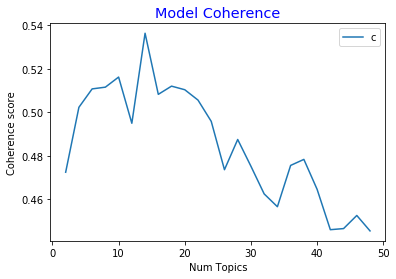

In [63]:
# Show graph
# Coherence scores
start= k_min
limit= k_max
step=pas;
x = range(start, limit, step)
plt.title("Model Coherence", color="b", fontsize="x-large")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

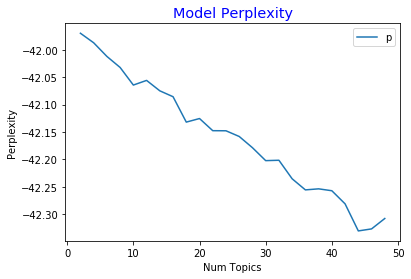

In [64]:
# Show graph
# Perplexity values
x = range(start, limit, step)
plt.title("Model Perplexity", color="b", fontsize="x-large")
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')
plt.show()

#### Visualize topics for best performing model

In [65]:
# Optimal model
optimal_k = list(range(k_min, k_max, step))[coherence_values.index(max(coherence_values))]
optimal_model = models.LdaModel(corpus=corpus_lemma, num_topics=optimal_k, id2word=dictionary_LDA_lemma, passes=10, random_state = 42)

In [66]:
vis_best_model = pyLDAvis.gensim.prepare(optimal_model, corpus_lemma, dictionary_LDA_lemma)
vis_best_model

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      22.264381  1        1      -0.156501  0.012359
6      11.960916  1        2      -0.040940 -0.122120
7      9.386033   1        3      -0.154135  0.103585
9      7.981184   1        4      -0.121762  0.027899
2      6.909556   1        5      -0.165428 -0.012405
11     6.608621   1        6      -0.021513 -0.069698
12     6.059154   1        7      -0.060779 -0.039110
5      5.991924   1        8       0.217472 -0.233498
8      5.578193   1        9       0.067199 -0.004882
10     4.703950   1        10     -0.088902 -0.058574
13     3.693045   1        11      0.128886  0.352060
4      3.599050   1        12     -0.098980 -0.012505
1      2.822939   1        13      0.160919  0.054003
3      2.441043   1        14      0.334463  0.002887, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
173   Default  7654.000000  file        7654.000000  30.0000  30.0000
194   Default  4476.000000  name        4476.000000  29.0000  29.0000
105   Default  3499.000000  http        3499.000000  28.0000  28.0000
209   Default  3719.000000  table       3719.000000  27.0000  27.0000
162   Default  2881.000000  com         2881.000000  26.0000  26.0000
280   Default  3927.000000  test        3927.000000  25.0000  25.0000
153   Default  3329.000000  -pron-      3329.000000  24.0000  24.0000
165   Default  3194.000000  database    3194.000000  23.0000  23.0000
86    Default  3064.000000  int         3064.000000  22.0000  22.0000
90    Default  4172.000000  return      4172.000000  21.0000  21.0000
134   Default  2871.000000  public      2871.000000  20.0000  20.0000
106   Default  3685.000000  page        3685.000000  19.0000  19.0000
109   Default  4260.000000  server      4260.000000  18.0000  18.0000
531   Default  5335.000000  class       5335.000000  17.0000  17.0000
111   Default  3253.000000  string      3253.000000  16.0000  16.0000
207   Default  2534.000000  sql         2534.000000  15.0000  15.0000
5     Default  3108.000000  control     3108.000000  14.0000  14.0000
166   Default  4317.000000  datum       4317.000000  13.0000  13.0000
89    Default  5498.000000  new         5498.000000  12.0000  12.0000
113   Default  4199.000000  user        4199.000000  11.0000  11.0000
385   Default  4259.000000  object      4259.000000  10.0000  10.0000
23    Default  4133.000000  type        4133.000000  9.0000   9.0000 
19    Default  3407.000000  project     3407.000000  8.0000   8.0000 
183   Default  1991.000000  html        1991.000000  7.0000   7.0000 
4     Default  9000.000000  code        9000.000000  6.0000   6.0000 
13    Default  2170.000000  form        2170.000000  5.0000   5.0000 
25    Default  4308.000000  value       4308.000000  4.0000   4.0000 
144   Default  1852.000000  str         1852.000000  3.0000   3.0000 
16    Default  4135.000000  net         4135.000000  2.0000   2.0000 
1180  Default  1689.000000  exception   1689.000000  1.0000   1.0000 
...       ...          ...  ...                 ...     ...      ... 
791   Topic14  71.461510    underscore  72.387352    3.6999  -6.0875 
1491  Topic14  85.005020    distance    86.164284    3.6992  -5.9139 
1245  Topic14  66.694283    house       67.620125    3.6990  -6.1565 
3274  Topic14  66.300575    alia        67.226418    3.6989  -6.1624 
1528  Topic14  64.542313    country     65.468155    3.6985  -6.1893 
7755  Topic14  62.432201    svc         63.358040    3.6980  -6.2225 
3466  Topic14  61.342854    validator   62.268700    3.6978  -6.2401 
194   Topic14  3861.583740  name        4476.547363  3.5650  -2.0978 
1329  Topic14  178.709793   bottom      200.799057   3.5962  -5.1709 
1153  Topic14  318.516113   float       381.861938   3.5314  -4.5929 
153   Topic14  2095.938232  -pron-      3329.411621  3.2500  -2.7089 
49    Topic14

In [67]:
for i,topic in optimal_model.show_topics(formatted=True, num_topics=40, num_words=5):
    print(str(i)+": "+ topic)
    print()

0: 0.015*"good" + 0.013*"will" + 0.013*"use" + 0.011*"can" + 0.010*"one"

1: 0.021*"byte" + 0.021*"character" + 0.020*"word" + 0.017*"ruby" + 0.015*"action"

2: 0.041*"test" + 0.022*"project" + 0.020*"code" + 0.017*"run" + 0.015*"build"

3: 0.123*"name" + 0.067*"-pron-" + 0.029*"div" + 0.018*"type" + 0.018*"style"

4: 0.027*"version" + 0.021*"control" + 0.021*"change" + 0.019*"tag" + 0.018*"branch"

5: 0.039*"int" + 0.037*"new" + 0.037*"public" + 0.037*"string" + 0.037*"return"

6: 0.028*"use" + 0.022*"class" + 0.021*"can" + 0.017*"object" + 0.017*"type"

7: 0.046*"use" + 0.017*"can" + 0.016*"java" + 0.015*"tool" + 0.014*"net"

8: 0.036*"page" + 0.026*"form" + 0.026*"control" + 0.021*"event" + 0.018*"javascript"

9: 0.031*"server" + 0.025*"user" + 0.022*"use" + 0.019*"can" + 0.018*"web"

10: 0.028*"exception" + 0.025*"error" + 0.022*"memory" + 0.018*"call" + 0.018*"code"

11: 0.043*"table" + 0.037*"database" + 0.030*"datum" + 0.030*"sql" + 0.021*"query"

12: 0.083*"file" + 0.021*"threa

### Finding the dominant topic in each sentence

In [68]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [69]:
df_topic_sents_tag= format_topics_sentences(ldamodel=optimal_model, corpus=corpus_lemma, texts=tokens_lemma)

# Format
df_dominant_topic = df_topic_sents_tag.reset_index()
df_dominant_topic.columns = ['Comment_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'TAGS', 'Text']

# Show
df_dominant_topic.head(5)

,Comment_No,Dominant_Topic,Topic_Perc_Contrib,TAGS,Text
0,0,2.0,0.5288,"test, project, code, run, build, work, can, get, visual, use","[want, use, track, bar, change, form, opacity, code, decimal, tran, trackbar, value, opacity, tran, build, application, give, follow, error, implicitly, convert, type, decimal, double, try, use, tran, double, control, doesn, work, code, work, fine, past, vb, net, project]"
1,1,8.0,0.2897,"page, form, control, event, javascript, text, browser, item, use, select","[absolutely, position, div, contain, several, child, one, relatively, position, div, use, percentage, base, width, child, div, collapse, width, internet, explorer, firefox, safari, use, pixel, width, work, parent, relatively, position, percentage, width, child, work, something, miss, easy, fix, besides, pixel, base, width, child, area, css, specification, cover]"
2,2,6.0,0.5743,"use, class, can, object, type, method, function, value, list, code","[explicit, cast, double, like, isn, necessary, double, tran, double, trackbar, value, identify, constant, sufficient, double, tran, trackbar, value, double, tran, trackbar, value]"
3,3,11.0,0.5814,"table, database, datum, sql, query, select, use, column, row, store","[give, datetime, represent, person, birthday, calculate, age, year]"
4,4,11.0,0.8461,"table, database, datum, sql, query, select, use, column, row, store","[give, specific, datetime, value, display, relative, time, like, hour, ago, day, ago, month, ago]"


In [70]:
df_dominant_topic.to_csv(path_or_buf="./dominant_topic_per_document.csv", sep=";", index=False, encoding="UTF-8")

### Find the most representative document for each topic

In [72]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_tag.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9690,"good, will, use, can, one, code, like, make, think, get","[game, maker, may, another, approach, can, start, simple, easy, drag, drop, development, introduce, advanced, programming, go, book, game, maker, apprentice, game, development, beginner, number, sample, game, take, step, require, make]"
1,1.0,0.8452,"byte, character, word, ruby, action, mvc, model, view, asp, end","[rawurlencode, will, encode, exotic, character, url]"
2,2.0,0.9484,"test, project, code, run, build, work, can, get, visual, use","[vista, gig, ram, plethora, virtual, machine, life, will, become, nice, whatev, don, go, bit, advantage, bit, bit]"
3,3.0,0.8914,"name, -pron-, div, type, style, color, width, document, element, height","[sample, code, think, look, follow, display, exactly, firefox, mac, ie, absdiv, position, absolute, leave, px, top, px, width, height, background, pctchild, width, height, background, ccc, reldiv, position, relative, left, px, top, px, height, px, width, background, red, div, -pron-, absdiv, div, -pron-, reldiv, div, div, -pron-, pctchild, div, div]"
4,4.0,0.8968,"version, control, change, tag, branch, svn, use, source, repository, file","[check, vistadb, good, product, server, version, beta, close, release]"


In [73]:
sent_topics_sorteddf.to_csv(path_or_buf="./representative_document_per_topic.csv", sep=";", index=False, encoding="UTF-8")

### Topics distribution across comments

In [75]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_tag['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_tag[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Comments', 'Perc_Comments']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Comments,Perc_Comments
0,2.0,"test, project, code, run, build, work, can, get, visual, use",7863.0,0.2868
1,8.0,"page, form, control, event, javascript, text, browser, item, use, select",282.0,0.0103
2,6.0,"use, class, can, object, type, method, function, value, list, code",1559.0,0.0569
3,11.0,"table, database, datum, sql, query, select, use, column, row, store",235.0,0.0086
4,11.0,"table, database, datum, sql, query, select, use, column, row, store",642.0,0.0234
5,11.0,"table, database, datum, sql, query, select, use, column, row, store",1147.0,0.0418
6,9.0,"server, user, use, can, web, application, service, client, request, send",3556.0,0.1297
7,5.0,"int, new, public, string, return, str, class, foo, void, var",3250.0,0.1186
8,11.0,"table, database, datum, sql, query, select, use, column, row, store",1460.0,0.0533
9,11.0,"table, database, datum, sql, query, select, use, column, row, store",2419.0,0.0882


## Supervised machine learning